# Grover's search for D-optimal sequences

In [2]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

from quantum import *
from math import log, ceil, floor
from lib import paf, psd


# search for D-optimal sequences length=5
seq_len = 5

In [3]:
def irange(start, end):
    return range(start, end+1)

def bits_to_seq(bitstring):
    return [-1 if i == '0' else 1 for i in bitstring]

def int_to_seq_pair(bitstring):
    bitmask = (2 ** seq_len) - 1 # 111...1 (length = N)
    # get first half of bitstring
    first_half = (bitstring >> seq_len) & bitmask
    # get second half
    second_half = bitstring & bitmask
    seq_A = bits_to_seq("{:0{width}b}".format(first_half, width=seq_len))
    seq_B = bits_to_seq("{:0{width}b}".format(second_half, width=seq_len))
    return (seq_A, seq_B)

In [4]:
def bitwise_and(integer):
    """
    Performs AND on each individual bit of the binary representation of `integer`
    """
    if integer == 0: return 0
    result = 1
    for i in range(int(log(integer, 2))):
        bitmask = 0b1 << i
        bit = (integer & bitmask) >> i
        result = result & bit
    return result

def is_doptimal(integer):
    A, B = int_to_seq_pair(integer)
    m = (seq_len - 1) // 2
    pafs = (paf(A, s) + paf(B, s) for s in irange(1, m))
    # PAF(A,s) + PAF(B,s) = 4k + 2   (for int k, for s = 1..m)
    # PAF(A,s) + PAF(B,s) = 2        (for A,B D-optimal)
    # subtract 2 (so that =0 for D-opt) and square to make non-negative
    S = sum((p - 2)**2 for p in pafs)
    # now we have a positive integer for non-D-optimal pairs
    # NOT then bitwise AND yields 1 if we had 0 (D-opt), otherwise yields 0
    x = np.uint32(S**2)
    return bitwise_and(~x)

def correct_dopt(integer):
    A, B = int_to_seq_pair(integer)
    m = (seq_len - 1) // 2
    pafs = (paf(A, s) + paf(B, s) for s in irange(1, m))
    return all(pafsum == 2 for pafsum in pafs)

from itertools import islice

'''
bad_dopts = (i for i in range(4 ** seq_len) if is_doptimal(i) == 1 and correct_dopt(i) == False)

start = 500
for i in list(islice(bad_dopts, start, start+12)):
    a, b = int_to_seq_pair(i)
    m = (seq_len - 1) // 2
    pafsum = sum(paf(a, s) + paf(b, s) for s in irange(1, m))
    print('a {} \t b {} \t pafsum={}  m={}'.format(a, b, pafsum, m))
'''
#dopt_ints = (i for i in range(4 ** seq_len) if correct_dopt(i))
#for i in list(islice(dopt_ints, 6)) + [1,4,5,124,967335]:
#    a,b = int_to_seq_pair(i)
#    isdopt = is_doptimal(i)
#    print('a', a, 'b', b, 'S', is_doptimal(i))


dopt = [i for i in range(4 ** seq_len) if is_doptimal(i) == 1]
print("found {} doptimal pairs length {}".format(len(dopt), seq_len))

iterations 0


<IPython.core.display.Javascript object>


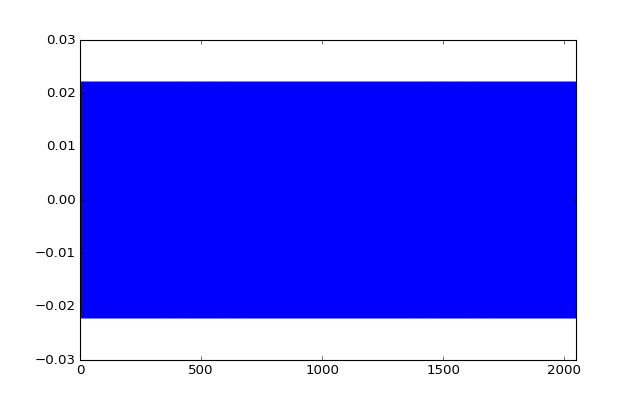

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[(0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-0.022097086912079598+0j),
 (0.022097086912079598+0j),
 (-

In [5]:
num_qubits = 2 * seq_len

# Set up quantum state.
input_register = (zero for _ in range(num_qubits))
state = Q(kron(*input_register, zero))

# Apply HX to the output register.
state = state.apply_gate(X, 0)
state = state.apply_gate(H, 0)

# Apply H^n to the input register.
# input register: qubits 1 to n
input_H = kron(*(H for _ in range(num_qubits)), I)
state = state.apply_unitary(input_H)

N = 2 ** num_qubits
# First, we'll compute the diffusion operator.
# this definition of D (the diffusion matrix aka. inversion about the mean)
# is given in Grover's original paper
P = 1/N * np.ones((N, N))
D = kron(-np.eye(N) + 2*P, I)

#iterations = floor((np.pi/4) * sqrt(N).real)
numsolns = {
    5: 100,
    9: 3888
}
M = numsolns[seq_len]
# optimal num. iterations => see Is-Quantum-Search-Practical (Viamontes)
iterations = floor(1/4 * np.pi * np.arcsin(np.sqrt(M/N)))
print('iterations', iterations)

# Perform the Grover iteration,
for i in irange(1, iterations):
    state = state.apply_func(is_doptimal)
    state = state.apply_unitary(D)

qubit_probs = to_row(state.state)
plt.plot(qubit_probs)
plt.xlim(0, len(qubit_probs))

qubit_probs